# CNNs and transfer learning

## Introduction

In the past lab we have used the high-level API of PyTorch to implement an MLP. We have seen how shifted images produced significantly worse results, while to the human eye the examples are equally recognisable.

In this lab we will use convolutional layers to increase translation invariance of images. We will start with implementing a convolutional model to perform classification on MNIST and then we will load a pretrained model and use transfer learning on a new dataset of fish images.


## Objectives
- Learn to create a simple CNN model in PyTorch
- Use torch cuda device to improve training performance 
- Understand and perform transfer learning using pretrained models

## Getting started

We will first import all necessary modules:

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


import numpy as np
import matplotlib.pyplot as plt

## Convolutional neural network

In order to build a CNN we use Convolutional layers from PyTorch. In the case of images we will need 2D convolutions.

## Exercise 1

Implement the following model using PyTorch:

```
- convolutional 1 input channel (grayscale images), 6 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- convolutional 6 input channels, 16 output channels, kernel 5x5, stride 1x1
- rectified linear unit
- max pooling 2x2
- flatten
- linear 120 output units
- rectified linear unit
- linear 84 output units
- rectified linear unit
- linear 10 output units
```

**Note:** we must provide the input dimension of the first linear layer. This will depend on how the convolutional and pooling layers have downsampled the input images. By carefully looking at the docs of PyTorch we can compute the output dimensions before the linear layer. The lazy way is: 
- put an arbitrary value
- print the shape of `x` after every operation
- run a forward on a single batch (you may obtain a single batch from a dataloader with `next(iter(my_dataloader))`
- check where it fails and correct the input dimension of that layer  

For now you may simply put your best guess and we will correct it after running the next cell.

In [2]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        ### BEGIN SOLUTION
        # intialisation of the layers and function used in the neural network
        self.conv1 = nn.Conv2d(1, 6, 5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = nn.Linear(in_features=256, out_features=120, bias=True)
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = nn.Linear(in_features=84, out_features=10, bias=True)
        self.relu = nn.ReLU()
        ### END SOLUTION


    def forward(self, x):
        ### BEGIN SOLUTION
        # define the forward function based on the required sequence of the network
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        ### END SOLUTION
        return x
# intialize the model and print the layers used in the model
model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu): ReLU()
)


## Exercise 2
Create the datasets and data loaders for the MNIST dataset as done in the previous lab. Take the first batch and run a forward of the model correcting the input dimension of the first `Linear` layer.

In [3]:
### BEGIN SOLUTION
# create training set of MMIST dataset 
train_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])
)

print(train_set)
# create testing set of MMIST dataset 
test_set = torchvision.datasets.MNIST(
    root="data/mnist",
    train=False,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5),(0.5))])
)
print(test_set)
### END SOLUTION

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/train-labels-idx1-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to data/mnist/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/mnist/MNIST/raw

Dataset MNIST
    Number of datapoints: 60000
    Root location: data/mnist
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )
Dataset MNIST
    Number of datapoints: 10000
    Root location: data/mnist
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=0.5, std=0.5)
           )


In [4]:
# Create the data loaders for train and test 
train_set_dataloader = torch.utils.data.DataLoader(train_set, batch_size=1, shuffle=True)
test_set_dataloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False)

In [5]:
# take an example from the training set to check the corrent dimensions of the first FC layer (fc1)
inputs = next(iter(train_set_dataloader))
print(inputs[1].item())


7


In [6]:
output = model(inputs[0])
print(output)

tensor([[ 0.0579, -0.0721, -0.0890, -0.1278, -0.0685,  0.0889,  0.0182,  0.0411,
          0.0106, -0.0854]], grad_fn=<AddmmBackward0>)


## Exercise 3

Train the model as done in the previous lab. Given that epochs take longer to compute with these models, we will print the average loss value every 1000 iterations. Write the train function so that every 1000 iterations it prints the average loss over these past 1000 iterations.

In [7]:
def train_model(model, dataloader, optimizer, criterion, n_epochs=1):
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.
        running_example = 0
        ## BEGIN SOLUTION
        #zero the gradient of the model
        with torch.no_grad():
              model.zero_grad()
        for i, batch in enumerate(dataloader):
        #1.zero the gradient of the model
              optimizer.zero_grad()
        #2.run a forward pass of the model on the mini-batch
              est = model.forward(batch[0]) 
              ref = batch[1] # true label 
        #3.calculate the error
              error = criterion(est, ref)
        #4. apply backward propagation 
              error.backward()
        #5. update the opitmizer step
              optimizer.step()
        #6. add the error to the running loss
              running_loss += error.item()
        # after 1000 iteration, calculate and print the average loss and increment the running_example
              if (i+1) % 1000 == 0:
                avg = running_loss/1000
                print(f'ep:   {epoch}, it:   {i}, loss: {avg}')
                running_example +=1
                running_loss = 0
                
            ## END SOLUTION


def evaluate_model(model, dataloader):
    model.eval()
    #1.intialize these variables 
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            ## BEGIN SOLUTION
            # calculate outputs by running images through the network
            out = model (data[0])
            # apply softmax to the output to get the propabilities 
            out = torch.softmax(out, dim=1)
            for idx, pred in enumerate (out):
            # the class with the highest energy is what we choose as prediction
              pred = torch.argmax(pred)
              if pred.item() == data[1][idx].item():
            # if the predicted label equals the true label for each image, increment the correct value
                correct += 1
            # increment total after checking an image
              total += 1    
    # calculate the accuracy and return its value
    accuracy = correct/total
    return accuracy
# take an instance of the Net() class and choose the criterion(cross entropy) and the optimizer (SGD)
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16
# create the train and test data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size)
# train the model 
train_model(model, train_loader, optimizer, criterion, n_epochs=2)
#test the model on the test set
accuracy = evaluate_model(model, test_loader)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
    

ep:   0, it:   999, loss: 2.110810416162014
ep:   0, it:   1999, loss: 0.4135200047176331
ep:   0, it:   2999, loss: 0.19215059297531842
ep:   1, it:   999, loss: 0.12781691873568343
ep:   1, it:   1999, loss: 0.10061781763774343
ep:   1, it:   2999, loss: 0.09866062747430987
Accuracy of the network on the test images: 97.6%


We notice that the change in architecture improves the accuracy obtained on the test set. However we also notice the training and testing takes longer. Convolutions are operations that can benefit significantly from GPU processing.

We will now learn how to move the data and operations to the GPU device to take advantage of its benefits.

The first thing to do is to obtain the GPU `device` if available, falling back to the CPU if the GPU is not available. This can be done with the following statement:

```
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
```

Then we may move the `nn.Module` that we want run in GPU:

```
model.to(device)
```

We must also move the data `inputs` and `labels` to the GPU before using them.

```
inputs, labels = inputs.to(device), labels.to(device)
```

**Note:** in Google's Collaboratory environment we may request running the Python kernel on a GPU. To do so go to the Menu > Runtime > Change runtime type. Only use this feature when needed to avoid using unnecessary ressources.

## Exercise 4

Re-train the model, this time on GPU.

In [8]:
from numpy.core.numeric import outer
def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    ## BEGIN SOLUTION
    #move model to the device ('gpu')
    model = model.to(device)
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.
        running_example = 0
        #zero the gradient of the model
        with torch.no_grad():
              model.zero_grad()
        for i, batch in enumerate(dataloader):
              #move the data inputs and labels to the device ('GPU') 
              inputs, labels = batch[0].to(device), batch[1].to(device)
        #1.zero the gradient of the optimizer           
              optimizer.zero_grad()
        #2.run a forward pass of the model on the mini-batch
              est = model.forward(inputs)
              ref = labels
        #3.calculate the error
              error = criterion(est, ref)
        #4. apply backward propagatio
              error.backward()
        #5. update the opitmizer step
              optimizer.step()
        #6. add the error to the running loss
              running_loss += error.item()
              # after log_every iteration, calculate and print the average loss and increment the running_example
              if (i+1) % log_every == 0:
                avg = running_loss/log_every
                print(f'ep:   {epoch}, it:   {i}, loss: {avg}')
                running_example +=1
                running_loss = 0
                
    ## END SOLUTION

def evaluate_model(model, dataloader, device='cpu'):
    ## BEGIN SOLUTION
    #move the model to the device
    model = model.to(device)
    model.eval()
    #1.intialize these variables 
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            # move the data to the device
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            out = model (inputs)
            # apply softmax to the output to get the propabilities
            out = torch.softmax(out, dim=1)
            ## END SOLUTION
            for idx, pred in enumerate (out):
            # the class with the highest energy is what we choose as prediction
              pred = torch.argmax(pred)
              if pred.item() == labels[idx].item():
            # if the predicted label equals the true label for each image, increment the correct value
                correct += 1
            # increment total after checking an image
              total += 1    
    # calculate the accuracy and return its value
    accuracy = correct/total
    return accuracy
    ## END SOLUTION
#obtain the GPU device if available, falling back to the CPU if the GPU is not available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# intialize the model and choose criterion and optimizer 
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 16
# create the train and test data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, num_workers=2)
# train the model 
train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
#evaluate the accuracy of the model on the test set
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the 10000 test images: {accuracy:.1%}')


ep:   0, it:   199, loss: 2.299113655090332
ep:   0, it:   399, loss: 2.2842866563796997
ep:   0, it:   599, loss: 2.2279658210277558
ep:   0, it:   799, loss: 1.7228566345572471
ep:   0, it:   999, loss: 0.8411637776345015
ep:   0, it:   1199, loss: 0.5523407773673534
ep:   0, it:   1399, loss: 0.4054672357812524
ep:   0, it:   1599, loss: 0.35739988401532174
ep:   0, it:   1799, loss: 0.2947093046084046
ep:   0, it:   1999, loss: 0.3027100198343396
ep:   0, it:   2199, loss: 0.2268946060584858
ep:   0, it:   2399, loss: 0.2075196243217215
ep:   0, it:   2599, loss: 0.19853866015560925
ep:   0, it:   2799, loss: 0.19196201995015144
ep:   0, it:   2999, loss: 0.20024453054880723
ep:   0, it:   3199, loss: 0.18189866635249927
ep:   0, it:   3399, loss: 0.155938789146021
ep:   0, it:   3599, loss: 0.11887910727411509
ep:   1, it:   199, loss: 0.13697621693369
ep:   1, it:   399, loss: 0.12438827043981292
ep:   1, it:   599, loss: 0.16423450655071065
ep:   1, it:   799, loss: 0.1215044172

In [9]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In this case the speed-up may not be too noticeable because the model is small. But we can now increase the number of convolutional filters without having a large impact on training time.

## Exercise 5

Try changing the number of filters of the first convolution to 16 and the next to 36.

In [10]:
# similar impelemnation of the pervious model but changing the number of filters of the first convolution to 16 and the next to 36
class Net(nn.Module):
    def __init__(self):
    ### BEGIN SOLUTION
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=1) #changing the number of filters of the first convolution to 16
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(16, 36, kernel_size=(5, 5), stride=(1, 1)) #changing the number of filters of the second convolution to 36
        self.fc1 = nn.Linear(in_features=576, out_features=120, bias=True)
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = nn.Linear(in_features=84, out_features=10, bias=True)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    ### END SOLUTION    
#obtain the GPU device if available, falling back to the CPU if the GPU is not available.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# take an instance of the Net() class and choose the criterion(cross entropy) and the optimizer (SGD)
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# train the model 
train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
#evaluate the accuracy of the model on the test set
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

ep:   0, it:   199, loss: 2.293367383480072
ep:   0, it:   399, loss: 2.245097508430481
ep:   0, it:   599, loss: 1.9143536400794983
ep:   0, it:   799, loss: 0.8033040799945593
ep:   0, it:   999, loss: 0.5179686389490962
ep:   0, it:   1199, loss: 0.36712517730891703
ep:   0, it:   1399, loss: 0.2873978851735592
ep:   0, it:   1599, loss: 0.2686818483937532
ep:   0, it:   1799, loss: 0.23393437767401337
ep:   0, it:   1999, loss: 0.22760640058200807
ep:   0, it:   2199, loss: 0.16902373613324018
ep:   0, it:   2399, loss: 0.1646898850053549
ep:   0, it:   2599, loss: 0.1603746633697301
ep:   0, it:   2799, loss: 0.1603625298431143
ep:   0, it:   2999, loss: 0.1615935846196953
ep:   0, it:   3199, loss: 0.14892379079479723
ep:   0, it:   3399, loss: 0.13028010333306156
ep:   0, it:   3599, loss: 0.09673131056828424
ep:   1, it:   199, loss: 0.11277487151906826
ep:   1, it:   399, loss: 0.10445936511503533
ep:   1, it:   599, loss: 0.13976173218223267
ep:   1, it:   799, loss: 0.097027

The accuracy of the model increased from 96.8% to 97.4% 

We will now test whether using CNN allows us to improve performance on the test set of shifted images. 

## Exercise 6
Create a new `test_shifted_set` and `test_shifted_loader` where images are shifted 3 pixels to the right and plot the first image. Use the transforms API of PyTorch (e.g. `transforms.Lambda`).

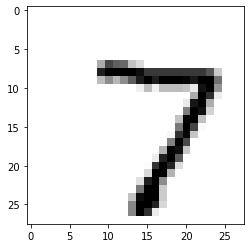

In [11]:
#create trasform to shift images by 3 pixels 
transform = transforms.Compose(
    [
     ### BEGIN SOLUTION
     transforms.ToTensor(),
     # using transforms.Lambda and using torch.roll to apply the shift
     transforms.Lambda(lambda x: torch.roll(x, shifts=3)) 
     ### END SOLUTION
    ])
#apply transform to the test set
test_shifted_set = torchvision.datasets.MNIST('data/mnist', download=True, train=False, transform=transform)

test_shifted_loader = torch.utils.data.DataLoader(test_shifted_set, batch_size=batch_size)
# plot the first image
first_shifted_image = test_shifted_set[0][0].squeeze()
plt.imshow(first_shifted_image, cmap='gray_r')


## Exercise 7

Test the performance of the previously trained model on the new test set.

In [12]:
### BEGIN SOLUTION
#Test the performance of the previously trained model on the shifted test set.
accuracy = evaluate_model(model, test_shifted_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
### END SOLUTION

Accuracy of the network on the test images: 67.0%


## [Optional] Exercise 8

Compare the performance of an MLP vs CNN for shifts of increasing number of pixels.

In [13]:
# create class for MyMLP to check the proformance of MLP
class MyMLP(nn.Module):
  def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 100)
        self.fc2 = nn.Linear(100, 10)
  def forward(self, x):
        x = torch.flatten(x,1)
        x = torch.sigmoid(self.fc1(x))
        x = self.fc2(x)
        return x
# take an instance of the MyMLP() class and choose the criterion(cross entropy) and the optimizer (SGD)
MLP_model = MyMLP()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(MLP_model.parameters(), lr=0.001, momentum=0.9)
# train the model 
train_model(MLP_model, train_loader, optimizer, criterion, n_epochs=2, device=device)
#evaluate the accuracy of the model on the shifted test set
accuracy = evaluate_model(MLP_model, test_shifted_loader, device=device)
print(f'Accuracy of the MLP network on the test images: {accuracy:.1%}')


ep:   0, it:   199, loss: 2.2242169511318206
ep:   0, it:   399, loss: 2.0025041276216506
ep:   0, it:   599, loss: 1.774306165575981
ep:   0, it:   799, loss: 1.4904107874631882
ep:   0, it:   999, loss: 1.3219629129767418
ep:   0, it:   1199, loss: 1.134972040951252
ep:   0, it:   1399, loss: 0.9468581421673298
ep:   0, it:   1599, loss: 0.8683360955119133
ep:   0, it:   1799, loss: 0.7816836623847485
ep:   0, it:   1999, loss: 0.7873229567706584
ep:   0, it:   2199, loss: 0.6915570051968097
ep:   0, it:   2399, loss: 0.6377234715223312
ep:   0, it:   2599, loss: 0.6096507728099823
ep:   0, it:   2799, loss: 0.5888981765508652
ep:   0, it:   2999, loss: 0.5651740802824498
ep:   0, it:   3199, loss: 0.5567681443691254
ep:   0, it:   3399, loss: 0.510044282451272
ep:   0, it:   3599, loss: 0.45308889463543894
ep:   1, it:   199, loss: 0.4616034178435802
ep:   1, it:   399, loss: 0.4196299222111702
ep:   1, it:   599, loss: 0.4756388744711876
ep:   1, it:   799, loss: 0.4302403609827160

The accuracy of MLP is very low compared to CNN

## [Optional] Exercise 9

Propose a solution (and optionally implement it) to make the models even more robust to shifts?

Your reponse here
My solution is:

1. Increase the kernel size of maxpooling layers to three. this lead to accuracy of 81%
2. create shifted training data set and train the model on it as well (apply different shifts)

In [14]:
class Net_modified(nn.Module):
    def __init__(self):
    ### BEGIN SOLUTION
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5, stride=1) #changing the number of filters of the first convolution to 16
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(16, 36, kernel_size=(5, 5), stride=(1, 1)) #changing the number of filters of the second convolution to 36
        self.fc1 = nn.Linear(in_features=324, out_features=120, bias=True)
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = nn.Linear(in_features=84, out_features=10, bias=True)
        self.relu = nn.ReLU()


    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x,1)
        #print(x.shape)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x
    ### END SOLUTION  
# take an instance of the Net_modified() class and choose the criterion(cross entropy) and the optimizer (SGD)
model = Net_modified()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# train the model 
train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device)
#evaluate the accuracy of the model on the shifted test set
accuracy = evaluate_model(model, test_shifted_loader, device=device)
print(f'Accuracy of the network on the shifted test images: {accuracy:.1%}')


ep:   0, it:   199, loss: 2.2900988733768464
ep:   0, it:   399, loss: 2.2349087941646575
ep:   0, it:   599, loss: 1.910886617898941
ep:   0, it:   799, loss: 0.9267640827596187
ep:   0, it:   999, loss: 0.5284677800908685
ep:   0, it:   1199, loss: 0.33994156563654543
ep:   0, it:   1399, loss: 0.24303787146229297
ep:   0, it:   1599, loss: 0.2269998473720625
ep:   0, it:   1799, loss: 0.19235982218757272
ep:   0, it:   1999, loss: 0.19209845021134242
ep:   0, it:   2199, loss: 0.1550110861682333
ep:   0, it:   2399, loss: 0.1418065141851548
ep:   0, it:   2599, loss: 0.14134925502818077
ep:   0, it:   2799, loss: 0.12726267255144194
ep:   0, it:   2999, loss: 0.1456364770687651
ep:   0, it:   3199, loss: 0.12244885651161894
ep:   0, it:   3399, loss: 0.11549454583320767
ep:   0, it:   3599, loss: 0.08465026682824828
ep:   1, it:   199, loss: 0.10589678708813154
ep:   1, it:   399, loss: 0.08810003090591635
ep:   1, it:   599, loss: 0.11129312674282119
ep:   1, it:   799, loss: 0.081

# Transfer learning

It is quite rare that we implement new models from scratch, specially when our target dataset is small.

We will often perform what is known as transfer learning: **start from well-established models pre-trained on large quantities of similar data**. For example, for natural image related tasks we will often start from a `ResNet` or `MobileNet`, whose weights have been trained on a classification task on ImageNet.

The model chosen to base our work on is often referred to as the **backbone**.

Depending on the task the pre-trained model may not be directly usable. Even when performing a classification task, the classes may not be the same, even the number of classes may vary. Therefore, for sure the output layer of the model may need to be modified (and re-trained).

PyTorch provides pre-trained models from [`torchvision.models`](https://pytorch.org/vision/stable/models.html) and from [PyTorch Hub](https://pytorch.org/hub/). Throughout this lab we will use the PyTorch Hub way.

For instance to download a [ResNet-18 model](https://pytorch.org/hub/pytorch_vision_resnet/) we would do:

```
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
```

To practice the methodology of transfer learning, we will use a small dataset provided by [here](https://groups.inf.ed.ac.uk/f4k/GROUNDTRUTH/RECOG/)

We will do the following steps:
1. Download the data and untar it
2. Create a dataset object using [torchvision.datasets.ImageFolder](https://pytorch.org/vision/stable/datasets.html?highlight=imagefolder#torchvision.datasets.ImageFolder)
3. Split the dataset into train and test using [sklearn.model_selection.train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
4. Train several models on the data
    1. A simple custom made CNN model
    2. A ResNet-18 without pretrained weights
    3. A ResNet-18 with pretrained weights training only the last layer

When splitting the data into train and test we will do a 80% / 20% ratio per each class (stratified). <!--We notice in the dataset that consecutive images seem to be extracted often from the same video segment, therefore we will split data in consecutive chunks instead of shuffling it (random split).-->

## Exercise 10
Download the data and untar it. Using `wget` (run with the `-nc` flag to avoid redownloading unnecessarily multiple times) and `tar`. Bash commands in Colab and Jupyter must be preceded by a `!`.

In [15]:
### BEGIN SOLUTION
#Download the data using wget 
!wget -nc https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar
### END SOLUTION

--2023-01-11 22:10:02--  https://homepages.inf.ed.ac.uk/rbf/fish4knowledge/GROUNDTRUTH/RECOG/Archive/fishRecognition_GT.tar
Resolving homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)... 129.215.32.113
Connecting to homepages.inf.ed.ac.uk (homepages.inf.ed.ac.uk)|129.215.32.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 510912000 (487M) [application/x-tar]
Saving to: ‘fishRecognition_GT.tar’

fishRecognition_GT. 100%[===================>] 487.24M   110MB/s    in 4.5s    

2023-01-11 22:10:06 (107 MB/s) - ‘fishRecognition_GT.tar’ saved [510912000/510912000]



In [16]:
#unzip the data
!tar xf fishRecognition_GT.tar

tar: A lone zero block at 997875


## Exercise 11
Create a `torchvision.datasets.ImageFolder` for the full fish recognition dataset and plot the first example.

In [17]:
# apply this transform to the images to feed them to the model with correct size
transform = transforms.Compose([
    transforms.Resize(224), # change size 
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Normalize(mean=[ 0.0048, -0.0226, -0.0251], std=[1.0334, 1.0325, 1.0342]) #Normalize the image to have a mean = 0 and standard deviation = 1
    ]
    )

### BEGIN SOLUTION
# create dataset from the image folder 
full_set = torchvision.datasets.ImageFolder('/content/fish_image' , transform=transform)
### END SOLUTION
# define the classes of the fishes
full_set.classes = [
                    'Dascyllus reticulatus',
                    'Plectroglyphidodon dickii',
                    'Chromis chrysura',
                    'Amphiprion clarkii',
                    'Chaetodon lunulatus',
                    'Chaetodon trifascialis',
                    'Myripristis kuntee',
                    'Acanthurus nigrofuscus',
                    'Hemigymnus fasciatus',
                    'Neoniphon sammara',
                    'Abudefduf vaigiensis',
                    'Canthigaster valentini',
                    'Pomacentrus moluccensis',
                    'Zebrasoma scopas',
                    'Hemigymnus melapterus',
                    'Lutjanus fulvus',
                    'Scolopsis bilineata',
                    'Scaridae',
                    'Pempheris vanicolensis',
                    'Zanclus cornutus',
                    'Neoglyphidodon nigroris',
                    'Balistapus undulatus',
                    'Siganus fuscescens'  	
]

In [18]:
print(len(full_set.classes))

23


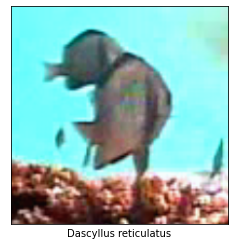

In [19]:
### BEGIN SOLUTION
# get the first image and plot it
first_example, label = full_set[0]
plt.imshow(first_example.permute(1,2,0))
plt.xticks([])
plt.yticks([])
plt.xlabel(full_set.classes[label])
plt.show()
### END SOLUTION

## Exercise 12

Using the [`sklearn.model_selection.train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and the labels from `full_set.targets` perform a stratified random split.

Then create the two new datasets `train_set` and `test_set` using [`torch.utils.data.Subset`](https://pytorch.org/docs/stable/data.html#torch.utils.data.Subset)

In [20]:
from sklearn.model_selection import train_test_split
#Using train_test_split and abels from full_set.targets perform a stratified random split
labels = list(full_set.targets)
indices = np.arange(len(labels))
# print(labels)
# print(indices)
# Random splits
### BEGIN SOLUTION
X_train, X_test, y_train, y_test = train_test_split(indices,labels, test_size=0.2, random_state=42, stratify=labels)
# create subset for train_set and test_set
train_set = torch.utils.data.Subset (full_set, X_train)
test_set = torch.utils.data.Subset (full_set, X_test)
### END SOLUTION

In [21]:
print(len(train_set))
print(len(test_set))


21896
5474


## Exercise 13

Compute on a batch of 500 random samples the mean and std deviation for each of the RGB channels. Set these in the `Normalize` transform of the full dataset of the previous cells in order to obtain a normalized version of the dataset.

In [22]:
# compute the mean and std deviation for each of the RGB channels on a batch of 500 random samples
loader = torch.utils.data.DataLoader(train_set, batch_size=500, shuffle=True, num_workers=1)
# take the sample
sample = next(iter(loader))
### BEGIN SOLUTION
#compute the mean and std deviation
std,mean = torch.std_mean(sample[0], dim = [0,2,3])

### END SOLUTION

In [23]:
print(sample[0].shape)

torch.Size([500, 3, 224, 224])


## Exercise 14

Before tackling transfer learning with an existing model, we will revisit the simple CNN and training procedure we built for MNIST earlier in this lab and make a few modifications.

1. We must first adapt the input to 3 channels (RGB)
2. Adapt the output of the network to the number of classes in our task
3. Increase the number of convolutional layers to 3 (we have larger images) with number of filters `[6, 16, 32]`
4. Adapt the number of inputs of the first fully connected layer
5. Increase the batch size to `64` to improve training time

In [24]:
#similar implementatio of the perivious class but make some modifications
class Net(nn.Module):
    ### BEGIN SOLUTION
    def __init__(self, n_classes) :
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, stride=1) #change the input to 3 channels (RGB)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=1)
        self.conv3 = nn.Conv2d(16, 36, kernel_size=(5, 5), stride=1) #create a third convolution layer
        self.fc1 = nn.Linear(in_features=20736, out_features=120, bias=True) #Adapt the number of inputs of the first fully connected layer
        self.fc2 = nn.Linear(in_features=120, out_features=84, bias=True)
        self.fc3 = nn.Linear(in_features=84, out_features=n_classes, bias=True) # Adapt the output of the network to the number of classes in our task
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        return x

    ### END SOLUTION

# define the training function
def train_model(model, dataloader, optimizer, criterion, n_epochs=1, log_every=200, device='cpu'):
    ## BEGIN SOLUTION
    #move model to the device ('gpu')
    model = model.to(device)
    model.train()

    for epoch in range(n_epochs):
        running_loss = 0.
        running_example = 0
        #zero the gradient of the model
        with torch.no_grad():
              model.zero_grad()
        for i, batch in enumerate(dataloader):
              #move the data inputs and labels to the device ('GPU') 
              inputs, labels = batch[0].to(device), batch[1].to(device)
        #1.zero the gradient of the optimizer           
              optimizer.zero_grad()
        #2.run a forward pass of the model on the mini-batch
              est = model.forward(inputs)
              ref = labels
        #3.calculate the error
              error = criterion(est, ref)
        #4. apply backward propagatio
              error.backward()
        #5. update the opitmizer step
              optimizer.step()
        #6. add the error to the running loss
              running_loss += error.item()
              # after log_every iteration, calculate and print the average loss and increment the running_example
              if (i+1) % log_every == 0:
                avg = running_loss/log_every
                print(f'ep:   {epoch}, it:   {i}, loss: {avg}')
                running_example +=1
                running_loss = 0
                
    ## END SOLUTION
#define the evalaiton function
def evaluate_model(model, dataloader, device='cpu'):
    ## BEGIN SOLUTION
    #move the model to the device
    model = model.to(device)
    model.eval()
    #1.intialize these variables 
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in dataloader:
            # move the data to the device
            inputs, labels = data[0].to(device), data[1].to(device)
            # calculate outputs by running images through the network
            out = model (inputs)
            # apply softmax to the output to get the propabilities
            out = torch.softmax(out, dim=1)
            ## END SOLUTION
            for idx, pred in enumerate (out):
            # the class with the highest energy is what we choose as prediction
              pred = torch.argmax(pred)
              if pred.item() == labels[idx].item():
            # if the predicted label equals the true label for each image, increment the correct value
                correct += 1
            # increment total after checking an image
              total += 1    
    # calculate the accuracy and return its value
    accuracy = correct/total
    return accuracy
    ## END SOLUTION
#Increase the batch size to 64 to improve training time
batch_size = 64
#create the data loaders for train_set and test_set
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

model = Net(len(full_set.classes))
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

ep:   0, it:   49, loss: 2.800206859111786
ep:   0, it:   99, loss: 1.755299036502838
ep:   0, it:   149, loss: 1.3421609222888946
ep:   0, it:   199, loss: 1.1716437327861786
ep:   0, it:   249, loss: 1.0507805752754211
ep:   0, it:   299, loss: 0.9945388734340668
ep:   1, it:   49, loss: 0.8960269069671631
ep:   1, it:   99, loss: 0.8374810659885407
ep:   1, it:   149, loss: 0.8193806427717208
ep:   1, it:   199, loss: 0.7996054148674011
ep:   1, it:   249, loss: 0.7326532471179962
ep:   1, it:   299, loss: 0.702877601981163
Accuracy of the network on the test images: 78.5%


We will now create two utility function to help us visualize the outputs of an image classification model.

## Exercise 15

Create a function that takes an image, a model and list of classes and plots the image and a horizontal bar plot (using [`plt.barh`](https://matplotlib.org/stable/gallery/lines_bars_and_markers/barh.html)) showing the probabilities assigned to the top 10 predicted classes (using [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html?highlight=topk#torch.topk)). Test it on the first image of the test set and using previous trained model.

**Note**: think of bringing back to the cpu and converting to numpy `my_np_array = my_torch_tensor.cpu().numpy()` torch tensors that are in the GPU.

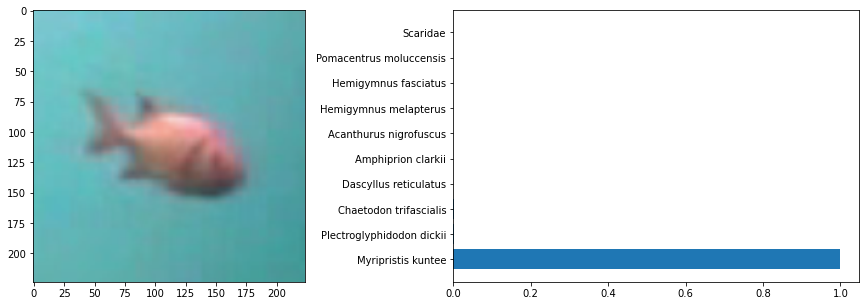

<Figure size 432x288 with 0 Axes>

In [60]:
def viz_image(image, model, classes, top=5, device='cpu'):
    assert image.ndim == 3, "Images are expected to have 3 dimensions: channels x height x width"
    was_training = model.training
    model.eval()
    with torch.no_grad():
        ### BEGIN SOLUTION
        fig, ax = plt.subplots(1, 2, figsize=[16,5])
        #plot the image
        ax[0].imshow(image.permute(1,2,0))
        # run the forward pass on the image
        out = model (image.unsqueeze(0).to(device))
        # get the output and indices of the top classes 
        prop_values, indices = torch.topk(out, top)
        # apply softmax to get propabilities 
        prop_values = torch.softmax(prop_values, dim=1)
        prop_values, indices = prop_values.cpu().numpy(), indices.cpu().numpy()
        classes = np.array(classes)
        top_classes = classes[indices]
        # Make a horizontal bar plot.
        ax[1].barh(top_classes[0],prop_values[0])
        plt.show()

        ### END SOLUTION

    plt.tight_layout()
    model.train(was_training)
#plot the first image on test_set and show the probabilities assigned to the top 10 predicted classes
image, label = test_set[0]
viz_image(image, model, full_set.classes,top=10, device=device)

## Exercise 16

Next we will visualize a batch of images and the class predicted by the model with it's probability in parentheses as their `xlabel`.
The function will also return the probabilites of all classes predicted for each image (tensor of `torch.float` with shape `(N, 1000)` where `N` is the number of images in the batch) and the class predicted by the model for each image (tensor of `torch.long` with shape `(N)`).

**Hint**: for create a grid of images consider the following snippet

```
fig = plt.figure(figsize=(10, 10))
for i, image in enumerate(images):
    ax = fig.add_subplot(n_rows, n_cols, i+1)

    # some code to normalize each image

    ax.imshow(...
```

**Note**: Normalize the pixels of each image between 0 and 1 before plotting it to obtain natural colors. Remember we need to do this, because each image was previously normalized to mean 0 and stddev 1 in order to be fed in the expected way by the model.

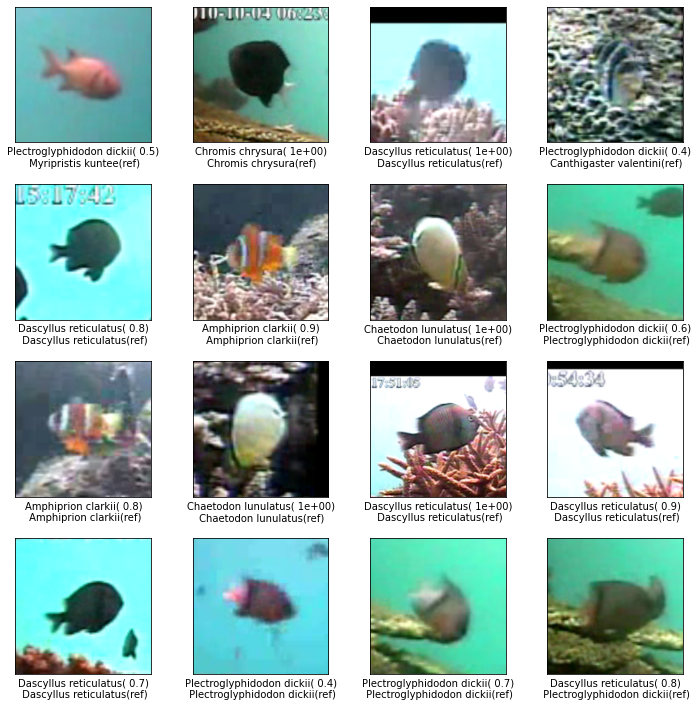

In [44]:
from numpy.ma.core import argmax
def viz_image_batch(images, model, classes, top=5, device='cpu', labels=None):
    assert images.ndim == 4, "Images are expected to have 4 dimensions: batch index x channels x height x width"
    model.to(device)

    was_training = model.training
    model.eval()
    # set size of the figure and divide it to four rows and four columns 
    fig = plt.figure(figsize=(10, 10))
    n_rows = 4 
    n_cols = 4
    probs = []
    max_class = []
    with torch.no_grad():
        ### BEGIN SOLUTION
        for i, image in enumerate(images):
          ax = fig.add_subplot(n_rows, n_cols, i+1)
          out = model (image.unsqueeze(0).to(device))
          out = torch.softmax(out, dim=1)
          out = out.cpu().numpy()
          ind = argmax(out)
          max_class.append(classes[ind])
          probs.append(out[0][ind])
          # define custom transform function to redo the trasform we did at the begining I_orginal = (I_normalized*std) + mean
          mean=[ 0.0048, -0.0226, -0.0251]
          std=[1.0334, 1.0325, 1.0342]
          # apply to RGB channels
          channel0 = image[0]*std[0]+mean[0]
          channel1 = image[1]*std[1]+mean[1]
          channel2 = image[2]*std[2]+mean[2]
          # stack them to create the image
          or_image = torch.stack([channel0,channel1,channel2],dim=2)
          ax.imshow(or_image)
          plt.xticks([])
          plt.yticks([])
          ax.set_xlabel(f'{max_class[i]}( {probs[i]:.1})\n {classes[labels[i]]}(ref)')
          ### END SOLUTION

    plt.tight_layout()
    model.train(was_training)
    
    return probs, max_class

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
probs, max_class= viz_image_batch(images, model, full_set.classes, labels=labels, device=device)

# ResNet model

ResNets are a family of models that have been popularized by their performance in image classification tasks. We will start by downloading a [ResNet18 model](https://pytorch.org/vision/stable/models.html#torchvision.models.resnet18) (a ResNet model composed of 18 layers). Other variants exist with varying number of layers: `resnet34`, `resnet50`, `resnet101`, `resnet152`.

When using an existing model with our particular task, we must first ensure that the inputs of the model are correctly matched.
- The images must have a size compatible with the model

In the case of resnet18, it expects images of size 224x224. In Exercise 11 we had created our datasets for the underwater images in a way that images were scaled (and cropped when necessary) to this size. 

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    ...
    ]
```
- The images must have been normalised in an equal (or similar) way

In [torchvision documentation](https://pytorch.org/vision/stable/models.html#:~:text=All%20pre%2Dtrained,0.229%2C%200.224%2C%200.225%5D) we find that the models expect images to be normalized with zero mean and standard deviation of 1.  For the natural images in ImageNet, this corresponds to the following transform:

```
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ]
```

However in this lab we have recomputed the statistics of a subsample of our data, since underwater images may have significantly different statistics. 

- The output of the model may need to be modified to match our class set

At first we will not change the output, however the following exercises will require changing the final layer of the model to adapt to our own class set.

## Exercise 17
We will start by downloading a pre-trained `resnet18` and visualizing how it classifies our own images into the ImageNet classes.
**Note**: in order to show the class labels with which it was trained, we could download ImageNet using [`torchvision.datasets.ImageNet`](https://pytorch.org/vision/stable/datasets.html#imagenet) and access the `.classes` attribute of the dataset. However this would take a long unnecessary time and bandwidth, since only the labels are needed. PyTorch is currently revisiting the API of pretrained models ([see here](https://github.com/pytorch/vision/pull/4610)) to solve this and other issues. In the meantime we can download the class list from [https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt](https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt).  

In [45]:
!wget -nc https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2023-01-11 22:26:59--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2023-01-11 22:26:59 (100 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [46]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
    imagenet_classes = [s.strip() for s in f.readlines()]

print(len(imagenet_classes))

1000


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


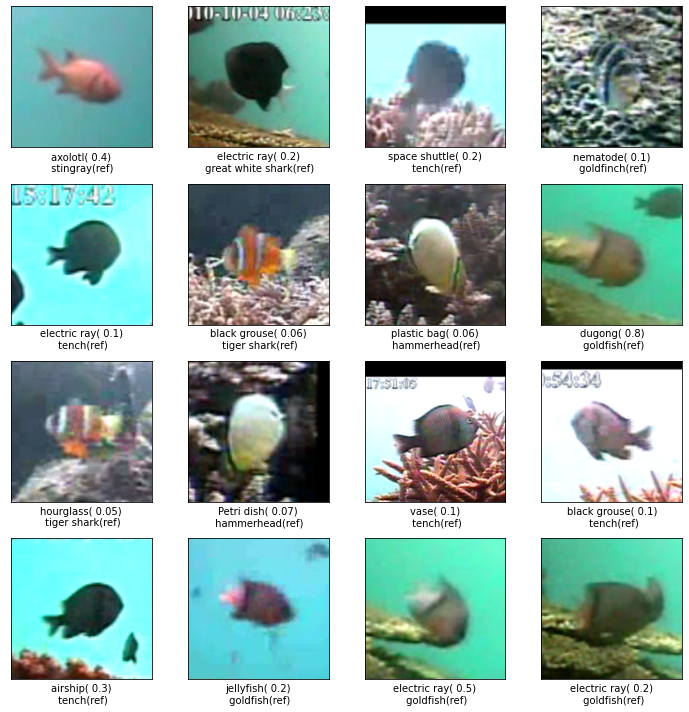

In [49]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)

images, labels = next(iter(test_loader))
probs, max_class = viz_image_batch(images, model, imagenet_classes, device=device, labels=labels)

In [48]:
labels

tensor([ 6,  2,  0, 11,  0,  3,  4,  1,  3,  4,  0,  0,  0,  1,  1,  1])

## Exercise 18

Comment on the results.


Your response here.

We are now going to explore different settings of reusing the resnet-18 model. We will start with a non-pretrained model, by initialising the weights randomly and training all layers using the standard training loop that we did before.

To achieve this our first step is to **replace the output layer** in order to output logits for the correct number of classes (those found in our data).

We will first print the resnet model and identify the last layer.

## Exercise 19

Print a non-pretrained resnet18 model and identify the name of the output layer.

In [51]:
### BEGIN SOLUTION
#Print a non-pretrained resnet18 model to identify the name of the output layer (fc).
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)
print(model)
### END SOLUTION

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


`fc` stands for Fully Connected, and it is the last layer in the model.

In order to replace it we must first remember it's input dimensionality, which can be obtained using `fc.in_features`.

## Exercise 20

Replace the `fc` layer of the vanilla resnet-18 by another `Linear` layer with as many outputs as classes in our fish dataset. Train the resulting model for 2 epochs and show the obtained accuracy.

In [52]:
# download non-pretrained model of resnet
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=False)

### BEGIN SOLUTION
# change the output of FC layer to 23 (no.classes)
model.fc.out_features = 23
### END SOLUTION
#choose the criterion (cross entropy)
criterion = nn.CrossEntropyLoss()
# choose optimizer (SGD)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# set the batch size = 64
batch_size = 64
# create data loaders for train set and test set 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)
# train the model
train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
# evaluate the model
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ep:   0, it:   49, loss: 2.9004831671714784
ep:   0, it:   99, loss: 1.3960756063461304
ep:   0, it:   149, loss: 1.0474403178691865
ep:   0, it:   199, loss: 0.9269765609502792
ep:   0, it:   249, loss: 0.7910691624879838
ep:   0, it:   299, loss: 0.7442341864109039
ep:   1, it:   49, loss: 0.6269563746452331
ep:   1, it:   99, loss: 0.586227907538414
ep:   1, it:   149, loss: 0.5144489604234695
ep:   1, it:   199, loss: 0.524272255897522
ep:   1, it:   249, loss: 0.48033628731966016
ep:   1, it:   299, loss: 0.465320511162281
Accuracy of the network on the test images: 79.7%


In [ ]:
model.fc.out_features

23

## Exercise 21

We will now try to leverage the large amount of natural imaging data from ImageNet, by using as backbone a pretrained resnet18 as starting point for training.


In [53]:
# download pretrained model of resnet and using as a backbone
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# change the output of FC layer to 23 (no.classes)
model.fc.out_features = 23

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ep:   0, it:   49, loss: 2.4403397834300993
ep:   0, it:   99, loss: 0.4074657712876797
ep:   0, it:   149, loss: 0.23539035648107529
ep:   0, it:   199, loss: 0.17751049980521202
ep:   0, it:   249, loss: 0.13360700093209743
ep:   0, it:   299, loss: 0.10915006686002016
ep:   1, it:   49, loss: 0.0810559996124357
ep:   1, it:   99, loss: 0.05731874046847224
ep:   1, it:   149, loss: 0.036329888133332135
ep:   1, it:   199, loss: 0.035545557960867884
ep:   1, it:   249, loss: 0.022660538144409655
ep:   1, it:   299, loss: 0.024510502833873033
Accuracy of the network on the test images: 98.7%


the acurracy of the pretrained model is very high compared to the no-pretrained one

## Exercise 22
In some situations it may be faster and better in terms of acheived accuracy, to only train the last layer, while letting all other layers with their pretrained weights. To freeze a layer you may simply set the `require_grad` attribute of its parameters to `False`.

Sometimes it is still beneficial to perform an additional training phase in which all weights are updated for a couple of epochs. This is known as **fine tuning**. In this exercise we will only be training the inserted layer.

Implement this method and visualize the results on the first batch of test.

**Note**: You may iterate over all parameters of a model calling its `.parameters()` method.

**Note**: Make sure to not freeze the latest layer that you added.


In [54]:
# download pretrained model of resnet and using as a backbone
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    
### BEGIN SOLUTION
#  freeze the layers of the network except the last fully connected layer by setting the require_grad attribute of its parameters to False
# last layer has two parameters (weight and bais)
params = [i for i in model.parameters()]
for idx in range(len(params)-2):
   params[idx].requires_grad = False
model.fc.out_features = 23
### END SOLUTION
#choose the criterion (cross entropy) and optimizer (SGD)

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64
#create data loaders for train set and test set 
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)
# train the model
train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
# evaluate the accuracy of the model
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ep:   0, it:   49, loss: 4.272121982574463
ep:   0, it:   99, loss: 1.7711147451400757
ep:   0, it:   149, loss: 1.3117254817485808
ep:   0, it:   199, loss: 1.1706438875198364
ep:   0, it:   249, loss: 1.0212357646226884
ep:   0, it:   299, loss: 0.9777057981491089
ep:   1, it:   49, loss: 0.8666486239433289
ep:   1, it:   99, loss: 0.8269637799263001
ep:   1, it:   149, loss: 0.7187596225738525
ep:   1, it:   199, loss: 0.7299741375446319
ep:   1, it:   249, loss: 0.666327320933342
ep:   1, it:   299, loss: 0.6651161843538285
Accuracy of the network on the test images: 85.2%


The accuracy of the model is decreased when letting the network to learn only the parameters of the final layer

## Exercise 23

Visualize the first batch of 16 images and it's predicted class in test.

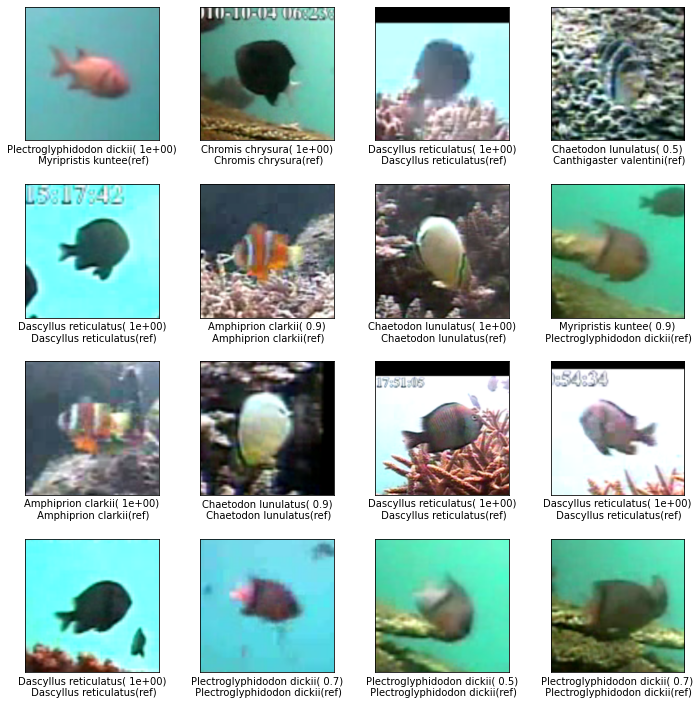

In [55]:
### BEGIN SOLUTION
#create test data loader with batch size = 16 
test_loader = torch.utils.data.DataLoader(test_set, batch_size=16, pin_memory=True, num_workers=2)
# take the first batch
images, labels = next(iter(test_loader))
# Visualize
probs, max_class= viz_image_batch(images, model, full_set.classes, labels=labels, device=device)
### END SOLUTION

## (optional) Exercise 24

Try with one (or all) of the following backbones: [`AlexNet`](https://pytorch.org/hub/pytorch_vision_alexnet/), [`VGG`](https://pytorch.org/hub/pytorch_vision_vgg/), [`MobileNetV2`](https://pytorch.org/hub/pytorch_vision_mobilenet_v2/)

In [ ]:
### BEGIN SOLUTION
# dowload pretrained VGG and use it  
model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg11', pretrained=True)
# identify the last layer and change the out_features to 23 (no.classes) 
model.classifier[6].out_features = 23

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
### END SOLUTION

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ep:   0, it:   49, loss: 1.9417859089374543
ep:   0, it:   99, loss: 0.7461492073535919
ep:   0, it:   149, loss: 0.43532771825790406
ep:   0, it:   199, loss: 0.34391453459858895
ep:   0, it:   249, loss: 0.286566556841135
ep:   0, it:   299, loss: 0.2069917117059231
ep:   1, it:   49, loss: 0.1720007935911417
ep:   1, it:   99, loss: 0.14448705211281776
ep:   1, it:   149, loss: 0.12593254894018174
ep:   1, it:   199, loss: 0.12760243779048325
ep:   1, it:   249, loss: 0.11435672050341963
ep:   1, it:   299, loss: 0.10555291537661106
Accuracy of the network on the test images: 97.9%


In [ ]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [ ]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

In [ ]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
### BEGIN SOLUTION
# dowload pretrained Alexnet and use it  
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=True)
# identify the last layer and change the out_features to 23 (no.classes) 
model.classifier[6].out_features = 23

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
### END SOLUTION

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


ep:   0, it:   49, loss: 1.8350510275363923
ep:   0, it:   99, loss: 0.671655479669571
ep:   0, it:   149, loss: 0.46550083726644514
ep:   0, it:   199, loss: 0.4164023670554161
ep:   0, it:   249, loss: 0.3373606872558594
ep:   0, it:   299, loss: 0.3068946023285389
ep:   1, it:   49, loss: 0.23370270058512688
ep:   1, it:   99, loss: 0.2410866376757622
ep:   1, it:   149, loss: 0.1847833777219057
ep:   1, it:   199, loss: 0.18282775163650514
ep:   1, it:   249, loss: 0.18561293452978134
ep:   1, it:   299, loss: 0.12920339152216911
Accuracy of the network on the test images: 97.5%


In [ ]:
#Download mobilenet backbone and use it
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=True)
# identify the last layer and change the out_features to 23 (no.classes) 
model.classifier[1].out_features = 23

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)

train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')


Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ep:   0, it:   49, loss: 2.3504004487395287
ep:   0, it:   99, loss: 0.33528536431491374
ep:   0, it:   149, loss: 0.17731242440640926
ep:   0, it:   199, loss: 0.14177150525152682
ep:   0, it:   249, loss: 0.11176861668005586
ep:   0, it:   299, loss: 0.08237568294629455
ep:   1, it:   49, loss: 0.06864381317049265
ep:   1, it:   99, loss: 0.05781188074499369
ep:   1, it:   149, loss: 0.026856867191381754
ep:   1, it:   199, loss: 0.026146907301153988
ep:   1, it:   249, loss: 0.02185213319491595
ep:   1, it:   299, loss: 0.023509864939842372
Accuracy of the network on the test images: 99.0%


In [ ]:
print(model)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

The accuracy of the four backbones used is very good and are very close to each other. Imagenet backbone gave an acurracy of 99% 

## (optional) Exercise 25

Perform fine tuning on one (or more) of the models we have done.

In [56]:
### BEGIN SOLUTION
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)
    
### freeze all layers except final linear layer
params = [i for i in model.parameters()]
for idx in range(len(params)-2):
   params[idx].requires_grad = False


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, pin_memory=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, pin_memory=True, num_workers=2)
### Train model for 2 epochs while freezing layers
print(f'fine tuning method')
print(f'step one : Freeze layers')
train_model(model, train_loader, optimizer, criterion, n_epochs=2, device=device, log_every=50)
print(f'step two : train all layers')
# unfreeze all layers
for i in model.parameters():
  i.requires_grad = True
train_model(model, train_loader, optimizer, criterion, n_epochs=1, device=device, log_every=50)
accuracy = evaluate_model(model, test_loader, device=device)
print(f'Accuracy of the network on the test images: {accuracy:.1%}')
### END SOLUTION

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


fine tuning method
step one : Freeze layers
ep:   0, it:   49, loss: 4.272121982574463
ep:   0, it:   99, loss: 1.7711147451400757
ep:   0, it:   149, loss: 1.3117254817485808
ep:   0, it:   199, loss: 1.1706438875198364
ep:   0, it:   249, loss: 1.0212357646226884
ep:   0, it:   299, loss: 0.9777057981491089
ep:   1, it:   49, loss: 0.8666486239433289
ep:   1, it:   99, loss: 0.8269637799263001
ep:   1, it:   149, loss: 0.7187596225738525
ep:   1, it:   199, loss: 0.7299741375446319
ep:   1, it:   249, loss: 0.666327320933342
ep:   1, it:   299, loss: 0.6651161843538285
step two : train all layers
ep:   0, it:   49, loss: 0.4671693217754364
ep:   0, it:   99, loss: 0.2656723587214947
ep:   0, it:   149, loss: 0.1595003991574049
ep:   0, it:   199, loss: 0.141783604696393
ep:   0, it:   249, loss: 0.10131314802914858
ep:   0, it:   299, loss: 0.08188043091446161
Accuracy of the network on the test images: 98.0%


The accuracy when using fine tuning is very good (98%) compared to 85% when training only the final layer as in example 22